In [1]:
import pandas as pd 
import numpy as np 
from scipy.signal import csd
import networkx as nx 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
covid_data= pd.read_csv("data/us.csv")
n_rows = len(covid_data)
daily_cases = covid_data["cases"].diff(1)
daily_deaths = covid_data["deaths"].diff(1)
covid_data["daily_cases"] = daily_cases
covid_data["daily_death"] = daily_deaths


In [6]:
covid_data

,date,cases,deaths,daily_cases,daily_death
0,2020-01-21,1,0,NaN,NaN
1,2020-01-22,1,0,0.0,0.0
2,2020-01-23,1,0,0.0,0.0
3,2020-01-24,2,0,1.0,0.0
4,2020-01-25,3,0,1.0,0.0
...,...,...,...,...,...
1153,2023-03-19,103784916,1133826,1424.0,0.0
1154,2023-03-20,103794703,1133964,9787.0,138.0
1155,2023-03-21,103813076,1134177,18373.0,213.0
1156,2023-03-22,103864888,1134913,51812.0,736.0


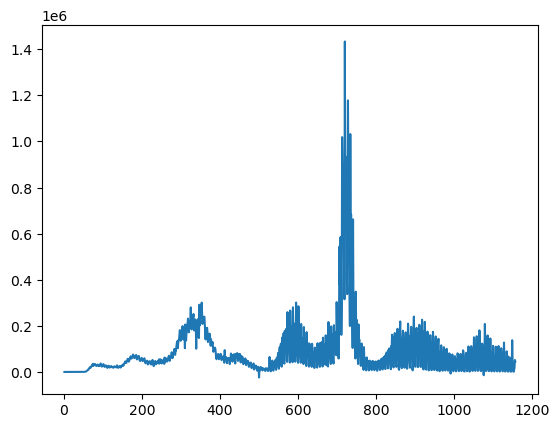

In [9]:
plt.plot(covid_data["daily_cases"])
#plt.plot(covid_data["deaths"])

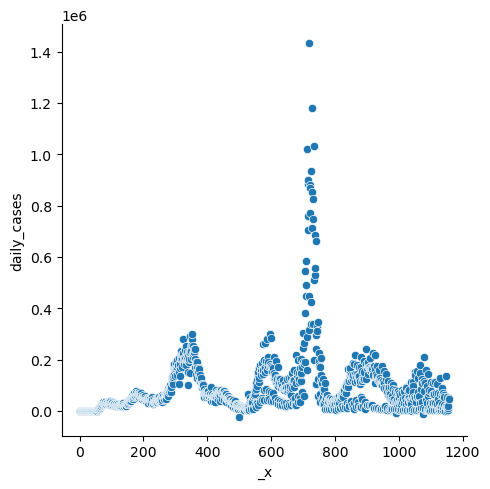

In [12]:
sns.relplot([i for i in range(n_rows)], covid_data["daily_cases"])

In [4]:
tweets = pd.read_csv("data/tweetid_userid_keyword_sentiments_emotions_United States.csv")


In [11]:
tweets["emotion"] = tweets["emotion"].fillna("N")

In [15]:
tweets_data = dict() 
def convertor(x):
    if(x in [-2,-1,0,1,2]):
        return [-2,-1,0,1,2].index(x)
    elif(x in ["N", "S", "H", "A","F"]):
        return ["N", "S", "H", "A","F"].index(x)+5
    else:
        print("Oh no this shound't happen at ", x )
        

for i in range(n_tweets):
    day = tweets["tweet_timestamp"][i].split(" ")[0]
    sent = tweets["sentiment"][i] 
    emote = tweets["emotion"][i] 
    if(day in tweets_data):
        tweets_data[day][convertor(sent)] += 1
        tweets_data[day][convertor(emote)] += 1
    else: 
        arr = [0 for i in range(10)]
        arr[convertor(sent)] = 1 
        arr[convertor(emote)] = 1
        tweets_data[day] = arr.copy() 

In [46]:
def dateNum(date):
    m_day = datetime.date(2022,6,2)
    parts = date.split("-")
    day = datetime.date(int(parts[0]),int(parts[1]),int(parts[2]))
    return (m_day - day).days



In [50]:
n = len(tweets_data)
dates = ["" for i in range(n)] 


measurement = np.zeros((n, 10))

for tweet in tweets_data:
    i = dateNum(tweet)
    measurement[i, :] = tweets_data[tweet]
    dates[i] = tweet 


In [53]:
twitter_cleaned = pd.DataFrame(measurement,
                               columns=["-2_sent","-1_sent","0_sent",
                                        "1_sent","2_sent",
                                          "N", "S", "H", "A","F"] )
twitter_cleaned.insert(0, "Date", dates)

In [27]:
import datetime 


'20220602'

In [55]:
twitter_cleaned.to_csv("data/twitter_aggr.csv")

In [39]:
day = datetime.date(2020,6,14)
day2 = datetime.date(2021,5,11)

In [45]:
(day2 - day).days

331